## Final Assignment (Deadline 12.03.2021)
## Julian Jung (3588413)

Import the necessary packages:

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

Define the parameters of the model:

In [2]:
sigma = 1
kappa = 0.3
beta = 0.995
phi_y = 0.1
phi_pi = 1.5
rho_mu = 0.7

### Task 1
A, M and D matrices of A\*z_t = M\*E_t[z_{t+1}] + D\*z_{t-1} + u_t. <br>
Also, to keep the code compact, I already state the inverse of A in this section:

In order to derive the A, M and D matrix, I write the model in matrix form. <br>
For this, I put the mu_t equation in the first row, the y_t equation in the second row, the pi_t equation in the third row and the i_t equation in the forth row. <br>
Then, I group the previous named variables in the vector z_t on the left hand side. On the right hand side, I group E_t\[z_{t+1}], z_{t-1} and error_t in respective vectors. <br>
Following, I infer from the equations of the model, the A, M and D matrices which give the coefficients to the previously created vectors.

In [3]:
A = np.array([[1,0,0,0],
              [0,1,0,1/sigma],
              [-1,-kappa,1,0],
              [0,0,0,1]])

A_inv = np.linalg.inv(A)

M = np.array([[0,0,0,0],
              [0,1,1/sigma,0],
              [0,0,beta,0],
              [0,0,0,0]])

D = np.array([[rho_mu,0,0,0],
              [0,0,0,0],
              [0,0,0,0],
              [0,phi_y,phi_pi,0]])

print("A = ",A)
print("A_inv = ", A_inv)
print("M = ",M)
print("D = ",D)

A =  [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   1. ]
 [-1.  -0.3  1.   0. ]
 [ 0.   0.   0.   1. ]]
A_inv =  [[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -1. ]
 [ 1.   0.3  1.  -0.3]
 [ 0.   0.   0.   1. ]]
M =  [[0.    0.    0.    0.   ]
 [0.    1.    1.    0.   ]
 [0.    0.    0.995 0.   ]
 [0.    0.    0.    0.   ]]
D =  [[0.7 0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.1 1.5 0. ]]


### Task 2
Function with input of guessed steady state and output of difference of realized-z-vector and input-z-vector.

Firstly, alternate A\*z_t = M\*E_t[z_{t+1}] + D\*z_{t-1} + u_t to
z_t = A_inv * (M\*^z_t + D*^z_t). Note that ^z_t refers to the input-z-vector. <br>
Secondly, calculate the difference of z_t and ^z_t.

In [4]:
def NewKey_1(z_guess):
    term_1 = np.dot(M,z_guess)        # the first term ín the right hand side brackets
    term_2 = np.dot(D,z_guess)        # the second term ín the right hand side brackets
    z = np.dot(A_inv,term_1 + term_2) # multiply A_inv with the two terms
                                       
    delta = z - z_guess               # the difference between the actual z values and the eq-z-guesses
    return delta                      # when the function is called, the difference will be the output of the function

An example of input eq-z-guesses and the deviation from the actually realized z-values:

In [5]:
init = np.ones(4) # example eq-z-guess of all four variables
NewKey_1(init)    # the difference between the realized z-values and the initial guesses

print("inputs = [z,pi,i,mu] =", init )
print("delta =",NewKey_1(init))

inputs = [z,pi,i,mu] = [1. 1. 1. 1.]
delta = [-0.3   -0.6    0.815  0.6  ]


### Task 3
Find the steady state and hence, the constant term of the MSV-solution using fsolve.

Firstly, initialize an input vector. Secondly, run the fsolve function with the previously defined New-Keyenesian function and the input vector.

In [6]:
init = np.ones(4)                                                         # the initial eq-guess as input for the function
[msv_coefficients,inf,ier,mes] = fsolve(NewKey_1,init,full_output=True)   # running fsolve with the initial eq-guess on our function

print("[z*,pi*,i*,mu*] =", msv_coefficients, "which is very close to 0.") 

[z*,pi*,i*,mu*] = [ 4.9e-324 -2.5e-323  1.5e-323  9.9e-324] which is very close to 0.


### Task 4
Find the matrices F and Q with the linear time iteration algorithm.

Firstly, define a function with the inputs A, M, D and F, and the outputs F and Q. <br>
Secondly, create a loop that iteratively calculates F depending on F's previous value, that stops if F is very close to the past F. Very close means that all entries on the respective same position of the matrices are be very similar. <br>
Thirdly, determine the Q matrix using the final F matrix.

In [7]:
def TimeIteration(A,M,D,F):
    F_max_diff = 1                                       # in order to allow the loop to start

    while F_max_diff > 0.000001:                         # condition that the loop keeps going until F has sufficiently converged
        F_new = np.dot(np.linalg.inv(A - np.dot(M,F)),D) # using linear time iteration formula for F_new
        F_max_diff = np.max(np.abs(F_new - F))           # F_max_diff gives max difference of entries at the same position of 
                                                            # both matrices
        F = F_new                                        # Fnew is saved as F to either use it in the next iteration of the loop
                                                            # or to use it as output and for Q

    Q  = np.linalg.inv(A - np.dot(M,F))                  # using linear time iteration formula to determine Q

    return F, Q                                          # returning the F and Q matrix

### Task 5
General solution of z_t using the previously defined Time Iteration function.

Call the created linear time iteration function with guessed F as input to obtain F and Q of z_t = F\*z_{t-1} + Q\*u_t.

In [8]:
F_guess = np.ones((4,4))            # the initial F guess as input for the linear time iteration function

# note that A, M and D are still defined by the previous code
F = TimeIteration(A,M,D,F_guess)[0] # assigning the F-output of the function to F, using [0] as it returned first
Q = TimeIteration(A,M,D,F_guess)[1] # assigning the Q-output of the function to Q, using [1] as it returned second

print("F =", F)
print("Q =", Q)

F = [[ 7.00000000e-01 -2.72576467e-19 -4.08864700e-18  0.00000000e+00]
 [-1.12112420e+00 -7.19280614e-02 -1.07892092e+00  0.00000000e+00]
 [ 6.96762347e-01 -1.63938939e-02 -2.45908409e-01  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-01  1.50000000e+00  0.00000000e+00]]
Q = [[ 1.00000000e+00  1.79505676e-17  1.13064137e-16 -1.79505676e-17]
 [-1.60160647e+00  7.19280614e-01 -7.65598324e-01 -7.19280614e-01]
 [ 9.95374721e-01  1.63938939e-01  6.28924380e-01 -1.63938939e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [9]:
# neat output by rounding:
print("rounded F =", np.around(F,2))
print("rounded Q =", np.around(Q,2))

rounded F = [[ 0.7  -0.   -0.    0.  ]
 [-1.12 -0.07 -1.08  0.  ]
 [ 0.7  -0.02 -0.25  0.  ]
 [ 0.    0.1   1.5   0.  ]]
rounded Q = [[ 1.    0.    0.   -0.  ]
 [-1.6   0.72 -0.77 -0.72]
 [ 1.    0.16  0.63 -0.16]
 [ 0.    0.    0.    1.  ]]


An example calculation of our model with exogenous z_{t-1} and u_t:

In [10]:
z_prev = np.array([0.2,0.2,0.2,0.2])         # z_prev describes z_{t-1}
u_pres = np.ones(4)                          # u_pres describes u_t

z_pres = np.dot(F,z_prev) + np.dot(Q,u_pres) # z_pres describes z_t and makes use of the previously determined F and Q matrices

print("z_{t-1} =", z_prev)
print("u_t =", u_pres)
print("z_t =", z_pres)

z_{t-1} = [0.2 0.2 0.2 0.2]
u_t = [1. 1. 1. 1.]
z_t = [ 1.14       -2.82159943  1.71119111  1.32      ]


### Task 6
Save C_mu, C_y, C_pi, C_err_mu and C_err_i.

The respective C vectors are columns in the F and Q matrices. Hence, the right columns must be "extracted" from the matrices.

In [11]:
C_mu     = F[:,0]  # the respective columns of the F matrix for z_{t-1}
C_y      = F[:,1]
C_pi     = F[:,2]
C_err_mu = Q[:,0]  # the respective columns of the Q matrix for the shocks
C_err_ni = Q[:,3]

print(C_mu)
print(C_y)
print(C_pi)
print(C_err_mu)
print(C_err_ni)

[ 0.7        -1.1211242   0.69676235  0.        ]
[-2.72576467e-19 -7.19280614e-02 -1.63938939e-02  1.00000000e-01]
[-4.08864700e-18 -1.07892092e+00 -2.45908409e-01  1.50000000e+00]
[ 1.         -1.60160647  0.99537472  0.        ]
[-1.79505676e-17 -7.19280614e-01 -1.63938939e-01  1.00000000e+00]


In [12]:
# neat output by rounding:
print("C_mu =", np.around(C_mu,2))
print("C_y =", np.around(C_y,2))
print("C_pi =", np.around(C_pi,2))
print("C_err_mu =", np.around(C_err_mu,2))
print("C_err_ni =", np.around(C_err_ni,2))

C_mu = [ 0.7  -1.12  0.7   0.  ]
C_y = [-0.   -0.07 -0.02  0.1 ]
C_pi = [-0.   -1.08 -0.25  1.5 ]
C_err_mu = [ 1.  -1.6  1.   0. ]
C_err_ni = [-0.   -0.72 -0.16  1.  ]


### Task 7
Effect of shock to mu in initial period.

In [13]:
T = 31  # number of periods

# Initializing the needed vectors for T periods. Note the _0 extension of the name to differentiate from Task 8.
mu_0     = np.zeros(T)
y_0      = np.zeros(T)
pi_0     = np.zeros(T)
ni_0     = np.zeros(T)
err_mu_0 = np.zeros(T)
err_ni_0 = np.zeros(T)

# The initial shock.
# Note that I initialize the shock in period 1 and not in period 0. I do this as I start the loop in period 1. I start the loop
# in period 1 as it is the earliest period that allows for the z_{t-1} vector. Note that if I started the loop in period 0,
# the z_{t-1} would equal z_[t-1] = z[0-1] = z[-1] = z[30]. Even though by our initialization this would deliver 0, this is
# not clean coding, as the loop would only work because of the lucky coincidents that z[30] happens to equal 0 by our
# initialization of the vectors.
err_mu_0[1] = 0.01

# Loop through the periods.
# Note that I prefer the explicit version over the list comprehension version.
# This is as it is more intuitive to understand the formula while not too much more code.
# The intuition is helpful as I use this loop in only slide variations multiple times in the remaining assignment.
# Hence, I think the tradeoff is ok to keep the more intuitive version.

for t in range(1,T): #make sure that x[t-1] starts in period 0, and not in x[t-1]=x[0-1]=x[-1]=x[30]. Hence, t = 1 as the start.
    mu_0[t] = (C_mu[0]*mu_0[t-1] + C_y[0]*y_0[t-1] + C_pi[0]*pi_0[t-1] +
             C_err_mu[0]*err_mu_0[t] + C_err_ni[0]*err_ni_0[t])
    y_0[t]  = (C_mu[1]*mu_0[t-1] + C_y[1]*y_0[t-1] + C_pi[1]*pi_0[t-1] +
             C_err_mu[1]*err_mu_0[t] + C_err_ni[1]*err_ni_0[t])
    pi_0[t] = (C_mu[2]*mu_0[t-1] + C_y[2]*y_0[t-1] + C_pi[2]*pi_0[t-1] +
             C_err_mu[2]*err_mu_0[t] + C_err_ni[2]*err_ni_0[t])
    ni_0[t] = (C_mu[3]*mu_0[t-1] + C_y[3]*y_0[t-1] + C_pi[3]*pi_0[t-1] +
             C_err_mu[3]*err_mu_0[t] + C_err_ni[3]*err_ni_0[t])

### Task 8
Effect of shock to interest rate in initial period.

In [14]:
# The comments of task 7 are still valid. Now I use the extension _1 instead of _0 as in task 7.

T = 31

mu_1     = np.zeros(T)
y_1      = np.zeros(T)
pi_1     = np.zeros(T)
ni_1     = np.zeros(T)
err_mu_1 = np.zeros(T)
err_ni_1 = np.zeros(T)

err_ni_1[1] = 0.01

for t in range(1,T):
    mu_1[t] = (C_mu[0]*mu_1[t-1] + C_y[0]*y_1[t-1] + C_pi[0]*pi_1[t-1] +
             C_err_mu[0]*err_mu_1[t] + C_err_ni[0]*err_ni_1[t])
    y_1[t]  = (C_mu[1]*mu_1[t-1] + C_y[1]*y_1[t-1] + C_pi[1]*pi_1[t-1] +
             C_err_mu[1]*err_mu_1[t] + C_err_ni[1]*err_ni_1[t])
    pi_1[t] = (C_mu[2]*mu_1[t-1] + C_y[2]*y_1[t-1] + C_pi[2]*pi_1[t-1] +
             C_err_mu[2]*err_mu_1[t] + C_err_ni[2]*err_ni_1[t])
    ni_1[t] = (C_mu[3]*mu_1[t-1] + C_y[3]*y_1[t-1] + C_pi[3]*pi_1[t-1] +
             C_err_mu[3]*err_mu_1[t] + C_err_ni[3]*err_ni_1[t])

### Task 9
Plot the z_t vectors for the two different initial shocks.

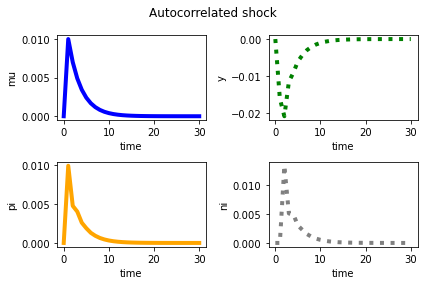

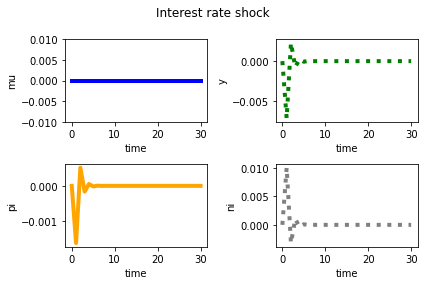

In [15]:
# Note that period 0 represents the period before the shock with all entries of z equal to 0.
# The shock happens in period 1.

# create x representing each period from 0 to T = 30
x = np.arange(T)

# For the diagrams I do not comment on the lines as I think the commands are self-explanatory and the code is well structured.
# the autocorrelated shock figure
plt.figure()

plt.suptitle("Autocorrelated shock")

plt.subplot(2,2,1)
plt.plot(x,mu_0, linewidth = 4, linestyle = 'solid', color = 'blue')
plt.xlabel('time')
plt.ylabel('mu')

plt.subplot(2,2,2)
plt.plot(x,y_0, linewidth = 4, linestyle = 'dotted', color = 'green')
plt.xlabel('time')
plt.ylabel('y')

plt.subplot(2,2,3)
plt.plot(x,pi_0, linewidth = 4, linestyle = 'solid', color = 'orange')
plt.xlabel('time')
plt.ylabel('pi')

plt.subplot(2,2,4)
plt.plot(x,ni_0, linewidth = 4, linestyle = 'dotted', color = 'grey')
plt.xlabel('time')
plt.ylabel('ni')

plt.tight_layout()
plt.show()


# The interest rate shock figure
plt.figure()

plt.suptitle("Interest rate shock")

plt.subplot(2,2,1)
plt.plot(x,mu_1, linewidth = 4, linestyle = 'solid', color = 'blue')
plt.xlabel('time')
plt.ylabel('mu')
plt.ylim(-0.01,0.01) # without the ylim the mu plot seems to be a curve,
                       # however, it is scaled to only very small numbers which is misleading.

plt.subplot(2,2,2)
plt.plot(x,y_1, linewidth = 4, linestyle = 'dotted', color = 'green')
plt.xlabel('time')
plt.ylabel('y')

plt.subplot(2,2,3)
plt.plot(x,pi_1, linewidth = 4, linestyle = 'solid', color = 'orange')
plt.xlabel('time')
plt.ylabel('pi')

plt.subplot(2,2,4)
plt.plot(x,ni_1, linewidth = 4, linestyle = 'dotted', color = 'grey')
plt.xlabel('time')
plt.ylabel('ni')

plt.tight_layout()
plt.show()

### Task 10
Intuition of the variables' responses.

After a one period positive shock to mu, which represents an autocorrelated shock to inflation, the following happens: <br>
A shock to mu is clearly represented in mu. After the initial jump by the exact size of the shock, mu steadily decreases until it converges to its initial value of 0. The steady and not abrupt decline is caused by the autocorrelation of the inflation shock which is represented by rho_mu = 0.7. Clearly, also inflation is affected by the shock to mu, as mu represents the autocorrelation of shocks to inflation. Hence, inflation's positive initial jump and the steady decline afterwards towards the initial value of 0 is very similar to the development of mu with the same intuition. The biggest cause of differences between mu's and inflation's development is caused by the effects of past inflation which can be inferred from C_pi. The intuition is that mu does not depend on past inflation values, while inflation indeed is negatively influenced by its past values and therefore converges faster. <br>
Output levels are quite strongly negatively affected by a shock to mu, despite mu not directly appearing in y's equation. However, the indirect effects via nominal interest rate and expectations about output and inflation cause the negative jump. Similarily, the nominal interest rate is only indirectly influenced via the past values of output and inflation. Contrary to the other variables, its rise is delayed as it does depend on past values. Afterwards, however, output and nominal interest steadily converge towards their initial values as the effects of the initial shock steadily decrease as rho_mu equals 0.7 which is smaller than 1. <br> <br>

After a one period positive shock to nominal interest rate, the following happens: <br>
The nominal interest rate jumps positively as it is clearly influenced by its shock. In future periods, the interest rate is additionally influenced by past values of output and inflation. While output's effect is quite small the inflation effect is positive and quite large. This leads to a quite strong negative reaction, due to the negative jump of inflation, even jumping slightly below the initial value of interest rate. Afterwards, however, nominal interest rate converges quite quickly. <br>
The inflation rate jumps slighlty down, followed by a jump overshooting the initial value and then converging quite quickly. The initial jump is caused by inflation rate's dependency on output level which indirectly delivers the effect of the interest rate shock. Future periods are still influenced by output which causes the convergence. <br>
Output jumps somewhat down, followed by a jump slightly passing the inital value, followed by quick convergence. This behavior is caused by outputs strong negative relation with interest rate and therefore also its shocks. As inflation barely jumps, its effects can be neglected. Thus, output's behavior mirrors the interest rate's behavior, only with a negative sign and with a smaller magnitude. <br>
The autocorrelated shock mu only depends on its shocks and its previous values. As no shocks to mu occur, mu never changes and stays at 0 for all periods. <br> 
We can explicitly note that after a shock to nominal interest rate, the model does not directly return to its steady state. This is caused by the above described indirect effects, e.g. inflation also being influenced by past values of output and inflation, which lead to a longer process of convergence towards the steady state. <br> <br>

Comparing the effects of both shocks, we can clearly see that both shocks have different effects on the variables. This shouldn't come as a surprise since inflation and interest rate influence the model differently. What is more interesting is firstly, the magnitude of the effects, and secondly, the speed of convergence. Both are explained by the autocorrelation. The autocorrelated shock ensures that future periods are still affected by the initial shock and its indirect effects, which makes the effect size larger and leads to a slower convergence towards the steady state value.

### Task 11
Output and inflation of 500 periods with random shocks saved in dataframe.

Number of periods and initializing the z-vectors:

In [16]:
# number of periods
T = 501

# initializing the vectors for T periods
mu     = np.zeros(T)
y      = np.zeros(T)
pi     = np.zeros(T)
ni     = np.zeros(T)

Initializing the shocks:

In [17]:
np.random.seed(0)                     # Random seed creates as if random data that stays the same, also if the code is executed again.
err_mu = np.random.standard_normal(T) # Shocks for each period drawn from the standard normal distribution.
                                      # Note that following the random.randn documentation, standard_normal should be preferred.
err_ni = np.random.standard_normal(T) # Shocks for each period drawn from the standard normal distribution.

Run the loop:

In [18]:
# the same loop as in tasks 7 and 8, now without the extension _x

for t in range(1,T): #make sure that x[t-1] starts in period 0, and not in x[t-1]=x[0-1]=x[-1]=x[500].
    mu[t] = (C_mu[0]*mu[t-1] + C_y[0]*y[t-1] + C_pi[0]*pi[t-1] +
             C_err_mu[0]*err_mu[t] + C_err_ni[0]*err_ni[t])
    y[t]  = (C_mu[1]*mu[t-1] + C_y[1]*y[t-1] + C_pi[1]*pi[t-1] +
             C_err_mu[1]*err_mu[t] + C_err_ni[1]*err_ni[t])
    pi[t] = (C_mu[2]*mu[t-1] + C_y[2]*y[t-1] + C_pi[2]*pi[t-1] +
             C_err_mu[2]*err_mu[t] + C_err_ni[2]*err_ni[t])
    ni[t] = (C_mu[3]*mu[t-1] + C_y[3]*y[t-1] + C_pi[3]*pi[t-1] +
             C_err_mu[3]*err_mu[t] + C_err_ni[3]*err_ni[t])

Bring the resulting z values in a dataframe for output and inflation:

In [19]:
df = pd.DataFrame({'Output_t':y,'Inflation_t':pi}) # bringing the np.arrays into a dataframe using a dictionary
                                                     # which is one way to properly assign names to the columns.

df

,Output_t,Inflation_t
0,0.000000,0.000000
1,-1.429475,0.218572
2,-1.980715,1.261108
3,-5.968607,2.886961
4,-8.758738,3.517486
...,...,...
496,-3.514556,0.805768
497,-0.291689,0.358713
498,1.171640,-0.820281
499,1.421612,-0.543025


For the intuition/ gaining a better feeling/ checking whether the numbers make sense:
a rudimentary plot of output and inflation:

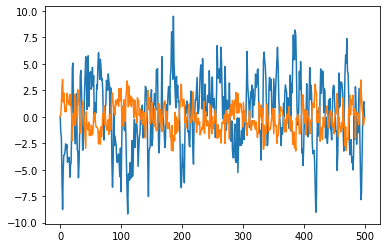

In [20]:
x = np.arange(T)

plt.figure()
plt.plot(x,y,x,pi)
plt.show()

### Task 12
Rational expectations of inflation using MSV to be included in the dataframe.

I start with E_t[z_{t+1}] = F\*E_t[z_t] + Q\*E_t[u_{t+1}]. <br> 
As errors are white noise, I know: E_t\[u_{t+1}] = 0. <br> 
Also, the expectations of the z vector of the same period is the realized vector itself: E_t[z_t] = z_t <br>
Hence, the expectations simplify to E_t\[z_{t+1}] = F*z_t. <br>
I am solely looking for the expectation of inflation which is the third entry of the expectation
vector.

In [21]:
# initializing the expectations vector, using the same T=500 as before
E_pi = np.zeros(T)

# Looping through the periods.
# Note that I make use of the previosly determined C-vectors and the mu, y and pi values.
# Note that I assign E_t[pi_{t+1}] to period t, namely to the period in which the expectations are formed. 
for t in range(T):
    E_pi[t] = C_mu[2]*mu[t] + C_y[2]*y[t] + C_pi[2]*pi[t]

# add E_t[pi_{t+1}] to the dataframe
df['E_t[Inflation_{t+1}]'] = E_pi

df

,Output_t,Inflation_t,E_t[Inflation_{t+1}]
0,0.000000,0.000000,0.000000
1,-1.429475,0.218572,0.248500
2,-1.980715,1.261108,0.599472
3,-5.968607,2.886961,1.563273
4,-8.758738,3.517486,2.102601
...,...,...,...
496,-3.514556,0.805768,0.682430
497,-0.291689,0.358713,0.134343
498,1.171640,-0.820281,-0.374387
499,1.421612,-0.543025,-0.333843


### Task 13
Forecast error represented by the difference of realized and expected inflation.

In [22]:
# shifting inflation one period backwards and thereby creating inflation_{t+1}:
df['Inflation_{t+1}'] = df['Inflation_t'].shift(periods=-1)

# drop the last period as Inflation(501) does not exist:
df = df.drop(500)

# determine the difference between realizations and expectations:
df['Delta'] = df['Inflation_{t+1}'] - df['E_t[Inflation_{t+1}]']

# reordering columns to an intuive order:
header_order = ['Output_t','Inflation_t','Inflation_{t+1}','E_t[Inflation_{t+1}]','Delta']
df = df.reindex(columns=header_order)

df

,Output_t,Inflation_t,Inflation_{t+1},E_t[Inflation_{t+1}],Delta
0,0.000000,0.000000,0.218572,0.000000,0.218572
1,-1.429475,0.218572,1.261108,0.248500,1.012608
2,-1.980715,1.261108,2.886961,0.599472,2.287489
3,-5.968607,2.886961,3.517486,1.563273,1.954213
4,-8.758738,3.517486,1.397496,2.102601,-0.705105
...,...,...,...,...,...
495,-7.243817,1.924288,0.805768,1.476717,-0.670949
496,-3.514556,0.805768,0.358713,0.682430,-0.323717
497,-0.291689,0.358713,-0.820281,0.134343,-0.954624
498,1.171640,-0.820281,-0.543025,-0.374387,-0.168639


For the intuition/ gaining a better feeling/ checking whether the numbers make sense:
a rudimentary plot of inflation, expected inflation, and the difference between both:

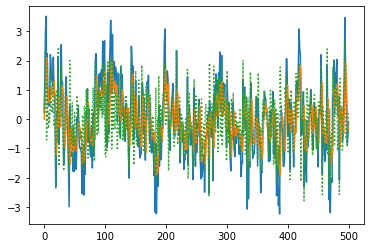

In [23]:
x = np.arange(T-1)
plt.figure()
plt.plot(x,np.array(df['Inflation_{t+1}']),x,np.array(df['E_t[Inflation_{t+1}]']))
plt.plot(x,np.array(df['Delta']), linestyle = 'dotted')
plt.show()

# in case the first diagram is to messy and the deltas should be displayed seperately
#plt.figure()
#plt.plot(x,np.array(df['Delta']))
#plt.show()

### Task 14
OLS regression of delta on inflation and interpretation.

In [24]:
endog = df['Delta']                        # input of dependent variable
exog  = sm.add_constant(df['Inflation_t']) # input of independent variable and adding a constant

model   = sm.OLS(endog,exog)               # initializing the OLS model
fit     = model.fit()                      # fitting the model

summary     = fit.summary()                # the standard econometric results table
alpha, beta = fit.params                   # the alpha and beta estimates

print(summary)
print('alpha =', alpha)
print('beta =', beta)

                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2911
Date:                Fri, 12 Mar 2021   Prob (F-statistic):              0.590
Time:                        20:05:27   Log-Likelihood:                -711.64
No. Observations:                 500   AIC:                             1427.
Df Residuals:                     498   BIC:                             1436.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0163      0.045     -0.362      

The intuition of alpha is that it captures a general systematic prediction error. The intuition of beta is that it captures the part of the prediction error that depends linearly on the current level of inflation. <br> <br>

Both, alpha and beta are only slighly different from zero and have large p-values, namely 0.72 and 0.59 respectively. Therefore, both coefficients are statistically non-significant. Hence, we can deduce that agents do not make systematic predicion errors irrespective of today's value of inflation. <br> <br>

This is contrary to the previous problem sets. Furthermore, using past values to determine the z-vector and autocorrelation give further motivation to look for systematic errors. However, the F-matrix with the C_mu vector accurately takes care of the autocorrelation and the other three columns of the F-matrix accurately take into account the other previous realization of z. <br> <br>

The white noise shocks bring the F-statistic down to a value of 0.29 as their variance of 1 is quite large since we consider a log-linearized model. However, the positive and negative shocks cancel each other out on average, keeping the expected values unbiased, and hence, leaving alpha and beta at zero.